In [ ]:
#importa as bibliotecas necessárias
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import time
import statistics as st

In [ ]:
#carrega dados
num_agentes = int(np.genfromtxt('m.csv', delimiter=","))
num_tarefas = int(np.genfromtxt('n.csv', delimiter=","))
mat_recurso_agente = np.genfromtxt('a.csv', delimiter=',')
mat_custo_tarefa = np.genfromtxt('c.csv', delimiter=',')
vet_capacidade = np.genfromtxt('b.csv', delimiter=',')

In [ ]:
#restrição de capacidade dos agentes
#return 1 -> restrição quebrada
def restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao):
    agente = 0
    quebra_total = 0

    while (agente < num_agentes):
      esforco = 0
      tarefa = 0
      while (tarefa < num_tarefas):
          esforco = esforco + mat_solucao[agente,tarefa]*mat_recurso_agente[agente,tarefa]
          tarefa += 1
      if (esforco > vet_capacidade[agente]):
          quebra_total = quebra_total + (esforco - vet_capacidade[agente])

      agente += 1
    return quebra_total

In [ ]:
#função objetivo fc()
def fobjc(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao, minn):
    isMin = minn
    custo = np.sum(mat_solucao * mat_custo_tarefa)

    if (isMin):
      custo = custo + restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao) * 10
    else:
      custo = custo - restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao) * 10

    return custo

In [ ]:
#função objetivo fe()
def fobje(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao, minn):
    maior_esforco = 0
    menor_esforco = 0
    agente = 0
    isMin = minn
    while (agente < num_agentes):
      esforco = 0
      tarefa = 0
      while (tarefa < num_tarefas ):
        esforco = esforco + mat_solucao[agente,tarefa]*mat_recurso_agente[agente,tarefa]
        tarefa += 1

      if (agente == 1):
        menor_esforco = esforco

      if (esforco > maior_esforco):
        maior_esforco = esforco.copy()
      elif (esforco < menor_esforco):
        menor_esforco = esforco.copy()
      agente += 1
    
    diferenca = maior_esforco - menor_esforco

    if (isMin):
      diferenca = diferenca + restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao) *1
    else:
      diferenca = diferenca - restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao) *1

    return diferenca

In [ ]:
#gera uma solucação inicial factível para o problema
def solucao_inicial(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade):
    mat_solucao_inicial = np.zeros((num_agentes, num_tarefas), int)
    vet_tarefa_concluida = np.zeros(num_tarefas)
    agente = 0
    while (agente < num_agentes):
        esforco = 0
        tarefa = 0
        while (tarefa < num_tarefas):
            esforco = esforco + mat_recurso_agente[agente,tarefa]
            if (vet_tarefa_concluida[tarefa] == 0 and esforco <= vet_capacidade[agente]):
                vet_tarefa_concluida[tarefa] = 1
                mat_solucao_inicial[agente][tarefa] = 1
            else:
                esforco = esforco - mat_recurso_agente[agente,tarefa]
            tarefa+=1
        agente+=1
    
    return mat_solucao_inicial

In [ ]:
#define as cinco estruturas de vizinhança
def vizinhanca(num_agentes, num_tarefas, mat_solucao, vizinho, estagnacao, mat_recurso_agent, estagnados):

    #Vizinhança Task Move
    if (vizinho == 1):
        tarefa = random.randint(0, num_tarefas-1)
        for i in range(num_agentes):
          if mat_solucao[i,tarefa] == 1:
            pos = i
            break
        agente = random.choice([lista for lista in range(num_agentes) if lista != pos])
        mat_solucao[:,tarefa] = 0
        mat_solucao[agente,tarefa] = 1

    #Vizinhança Swap
    elif (vizinho == 2):
        tarefa1 = random.randint(0, num_tarefas-1)
        tarefa2 = 0
        for i in range(num_agentes):
          if mat_solucao[i,tarefa1] == 1:
            agente1 = i
            break
        agente2 = random.choice([lista for lista in range(num_agentes) if lista != agente1])
        tarefa_shuffle = list(range(num_tarefas))
        random.shuffle(tarefa_shuffle)
        for i in tarefa_shuffle:
          if mat_solucao[agente2,i] == 1:
            tarefa2 = i
            break
        mat_solucao[:,tarefa1] = 0
        mat_solucao[:,tarefa2] = 0
        mat_solucao[agente2,tarefa1] = 1
        mat_solucao[agente1,tarefa2] = 1
              
    #seleciona aleatoriamente duas tarefas e troca seus agentes
    elif (vizinho == 3):
        tarefa1 = random.randint(0, num_tarefas-1)
        tarefa2 = random.randint(0, num_tarefas-1)
        aux = np.copy(mat_solucao[:, tarefa1])
        mat_solucao[:,tarefa1] = np.copy(mat_solucao[:, tarefa2])
        mat_solucao[:,tarefa2] = np.copy(aux)
      
    #troca todas as colunas com a coluna a sua direita
    elif (vizinho == 4): 
        coluna = 0
        while (coluna < num_tarefas - 1):
            linha = 0
            while (linha < num_agentes):
                aux = np.copy(mat_solucao[linha,coluna])
                mat_solucao[linha,coluna] = np.copy(mat_solucao[linha,coluna+1])
                mat_solucao[linha,coluna+1] = np.copy(aux)
                linha+=1
            coluna+=2           

    #seleciona aleatoriamente duas linhas e as troca 
    elif (vizinho == 5):
        agente1 = random.randint(0, num_agentes-1)
        agente2 = random.randint(0, num_agentes-1)
        aux = np.copy(mat_solucao[agente1, :])
        mat_solucao[agente1,:] = np.copy(mat_solucao[agente2, :])
        mat_solucao[agente2,:] = np.copy(aux)
    
    if (estagnados > 4):
        agente1 = random.randint(0, num_agentes-1)
        agente2 = random.randint(0, num_agentes-1)
        aux = np.copy(mat_solucao[agente1, :])
        mat_solucao[agente1,:] = np.copy(mat_solucao[agente2, :])
        mat_solucao[agente2,:] = np.copy(aux)
    
    return mat_solucao

In [ ]:
def SA(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, funcc, minn):
    vizinho = 1
    #temperatura inicial
    tk = 100
    #contador de estágios estagnados
    estagios_estagnados = 0
    isFunc = funcc
    isMin = minn

    #contador de avaliações da função f()
    nfe = 0
    
    #encontrando a solução inicial e a definindo como melhor solução
    mat_solucao_atual = solucao_inicial(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade)
    mat_melhor_solucao = np.copy(mat_solucao_atual)

    if (isFunc):
      custo_atual = fobjc(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_melhor_solucao, isMin)
    else:
      custo_atual = fobje(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_melhor_solucao, isMin)

    melhor_custo = custo_atual.copy()
    
    vet_custos = []
    vet_custos.append(custo_atual)
    fevalin = melhor_custo.copy()

    while (estagios_estagnados <= 10 and nfe < 10000):

        num_aceites = 0
        num_tentativas = 0
        
        fevalin = melhor_custo.copy()        

        while (num_aceites < 12*num_tarefas and num_tentativas < 100*num_tarefas):

            if (vizinho > 5):
                vizinho = 1
            mat_solucao_prox = vizinhanca(num_agentes, num_tarefas, mat_solucao_atual, vizinho, estagios_estagnados, mat_recurso_agente, estagios_estagnados)

            if (isFunc):
              custo_prox = fobjc(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao_prox, isMin)
            else:
              custo_prox = fobje(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao_prox, isMin)

            nfe+=1
            
            delta_e = custo_prox - custo_atual
            
            aleatorio = random.uniform(0,1)
            if (isMin):              
              if (delta_e <= 0 or (aleatorio <= np.exp(-delta_e/tk))):
                  
                  mat_solucao_atual = np.copy(mat_solucao_prox)
                  custo_atual = custo_prox.copy()

                  num_aceites+=1
                  
                  if (custo_atual < melhor_custo):#and restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao_atual) == 0):
                      vizinho = 1
                      mat_melhor_solucao = np.copy(mat_solucao_atual)
                      melhor_custo = custo_atual.copy()
                  else:
                    vizinho += 1
              else:
                vizinho += 1
            else:
              if (delta_e > 0 or (aleatorio <= np.exp(delta_e/tk))):

                  mat_solucao_atual = np.copy(mat_solucao_prox)
                  custo_atual = custo_prox.copy()

                  num_aceites+=1
                  
                  if (custo_atual > melhor_custo):# and restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao_atual) == 0):
                      vizinho = 1
                      mat_melhor_solucao = np.copy(mat_solucao_atual)
                      melhor_custo = custo_atual.copy()
                  else:
                    vizinho += 1
              else:
                vizinho += 1

            num_tentativas+=1

            #armazena o custo corrente
            vet_custos.append(custo_atual)
            
        #atualiza a temperatura
        tk = 0.5*tk
        if (tk < 0.1):
          tk = 100
        
        #avalia critério de estagnação
        if (isMin):
          if (melhor_custo < fevalin):
              estagios_estagnados = 0
          else:
              estagios_estagnados += 1
        else:
          if (melhor_custo > fevalin):
              estagios_estagnados = 0
          else:
              estagios_estagnados += 1 
    plt.plot(vet_custos)
    plt.ylabel('Custo')
    plt.xlabel('Iteração')
    plt.show()
    return mat_melhor_solucao, melhor_custo, vet_custos

In [ ]:
def get_vet_custos():
  mat_melhor_solucao, melhor_custo, vet_custos = SA(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, True, True)
  min_fc = melhor_custo
  mat_melhor_solucao, melhor_custo, vet_custos = SA(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, True, False)
  max_fc = melhor_custo
  mat_melhor_solucao, melhor_custo, vet_custos = SA(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, False, True)
  min_fe = melhor_custo
  mat_melhor_solucao, melhor_custo, vet_custos = SA(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, False, False)
  max_fe = melhor_custo
  return min_fc, max_fc, min_fe, max_fe

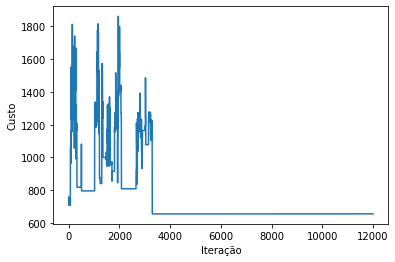

Tempo de execução: 5.61529541015625
Melhor custo: 655.0
Menor custo: 655.0
Maior custo: 1862.6
Média: 754.6425322782173
Desvio padrão: 203.03422429109733


In [ ]:
inicio = time.time()
mat_melhor_solucao, melhor_custo, vet_custos = SA(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, True, True)
fim = time.time()
print('Tempo de execução:', fim - inicio)
print('Melhor custo:', melhor_custo)
print('Menor custo:', min(vet_custos))
print('Maior custo:', max(vet_custos))
print('Média:', st.mean(vet_custos))
print('Desvio padrão:', st.pstdev(vet_custos))
#print('Soluções factíveis:', vet_custos_sem_quebra)

In [ ]:
#valida se a melhor solução quebrou a restrição de capacidade do agente
quebra = restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_melhor_solucao)
quebra

0

In [ ]:
class Objetivo:
  def __init__(self, c_min, c_max, e_min, e_max):
    self.c_min = c_min
    self.c_max = c_max
    self.e_min = e_min
    self.e_max = e_max

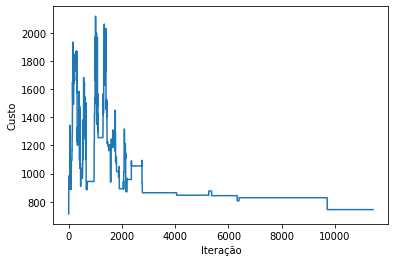

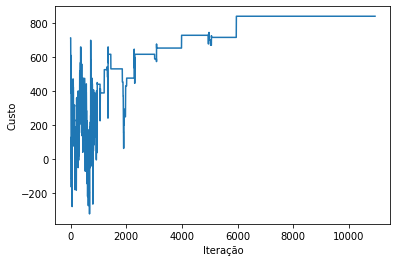

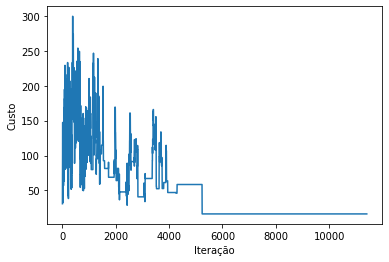

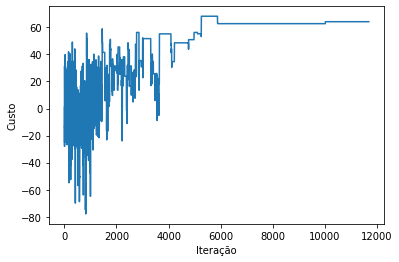

In [ ]:
min_fc, max_fc, min_fe, max_fe = get_vet_custos()

normalizacao = Objetivo(min_fc, max_fc, min_fe, max_fe)

In [ ]:
normalizacao.c_max,normalizacao.c_min,normalizacao.e_max,normalizacao.e_min

(841.4, 714.0, 68.24000000000001, 16.42)

In [ ]:
#Nova função objetivo com os diferentes objetivos normalizados normalizados
def fobj_norm (num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao, normalizacao, fator_custo):
    
    custo = np.sum(mat_solucao * mat_custo_tarefa)
    custo = custo + restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao) * 10
    
    maior_esforco = 0
    menor_esforco = 0
    agente = 0
    while (agente < num_agentes):
      esforco = 0
      tarefa = 0
      while (tarefa < num_tarefas ):
        esforco = esforco + mat_solucao[agente,tarefa]*mat_recurso_agente[agente,tarefa]
        tarefa += 1

      if (agente == 1):
        menor_esforco = esforco

      if (esforco > maior_esforco):
        maior_esforco = esforco.copy()
      elif (esforco < menor_esforco):
        menor_esforco = esforco.copy()
      agente += 1
    
    diferenca = maior_esforco - menor_esforco
    diferenca = diferenca + restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao) *1
    
    obj_custo = (fator_custo) * (custo - normalizacao.c_min)/(normalizacao.c_max - normalizacao.c_min)
    obj_dif = (1 - fator_custo) * (diferenca - normalizacao.e_min)/(normalizacao.e_max - normalizacao.e_min)

    retorno_obj = obj_custo + obj_dif

    return retorno_obj

In [ ]:
def SA_norm(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, normalizacao, fator_custo):
    vizinho = 1
    #temperatura inicial
    tk = 100
    #contador de estágios estagnados
    estagios_estagnados = 0

    #contador de avaliações da função f()
    nfe = 0
    
    #encontrando a solução inicial e a definindo como melhor solução
    mat_solucao_atual = solucao_inicial(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade)
    mat_melhor_solucao = np.copy(mat_solucao_atual)

    custo_atual = fobj_norm(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_melhor_solucao, normalizacao, fator_custo)

    melhor_custo = custo_atual.copy()
    
    vet_custos = []
    vet_custos.append(custo_atual)
        
    while (estagios_estagnados <= 10 and nfe < 10000):

        num_aceites = 0
        num_tentativas = 0
        na = 1

        fevalin = melhor_custo.copy()

        while (num_aceites < 12*num_tarefas and num_tentativas < 100*num_tarefas):

            if (vizinho > 5):
                vizinho = 1
            mat_solucao_prox = vizinhanca(num_agentes, num_tarefas, mat_solucao_atual, vizinho, estagios_estagnados, mat_recurso_agente,estagios_estagnados)
            custo_prox = fobj_norm(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao_prox, normalizacao, fator_custo)

            nfe+=1
            
            delta_e = custo_prox - custo_atual
            
            # print("Temperatura: " + str (tk))
            # print("Divisão: " +str (-delta_e/tk))
            aleatorio = random.uniform(0,1)

            if (delta_e <= 0 or (aleatorio <= math.exp(-delta_e/tk))):

                mat_solucao_atual = np.copy(mat_solucao_prox)
                custo_atual = custo_prox.copy()

                num_aceites+=1
                
                if (custo_atual < melhor_custo and restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao_atual) == 0):
                    vizinho = 1
                    mat_melhor_solucao = np.copy(mat_solucao_atual)
                    melhor_custo = custo_atual.copy()
                else:
                    vizinho += 1
            
            num_tentativas+=1

            #armazena o custo corrente
            vet_custos.append(custo_atual)
            
        #atualiza a temperatura
        tk = 0.7*tk
        if (tk < 0.5):
          tk = 100
        
        #avalia critério de estagnação
        if (melhor_custo < fevalin):
            estagios_estagnados = 0
        else:
            estagios_estagnados += 1
        
    plt.plot(vet_custos)
    plt.ylabel('Custo')
    plt.xlabel('Iteração')
    plt.show()
    return mat_melhor_solucao, melhor_custo, vet_custos

In [ ]:
class front_pareto:
  def __init__(self, matrix, norm, custo, dif, fator):
    self.matrix = matrix
    self.norm = norm
    self.custo = custo
    self.dif = dif
    self.fator = fator

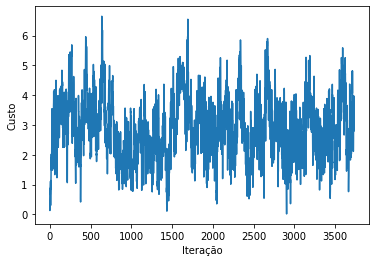

Fator Custo:  0
Objetivo Custo:  729.0
Objetivo Diferença:  23.0



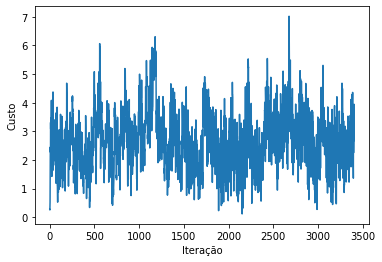

Fator Custo:  0.05
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



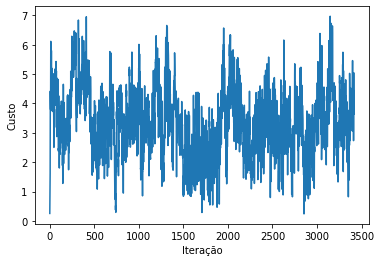

Fator Custo:  0.1
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



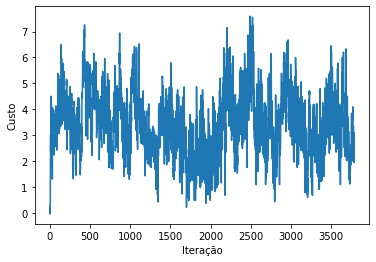

Fator Custo:  0.15000000000000002
Objetivo Custo:  726.0
Objetivo Diferença:  13.0



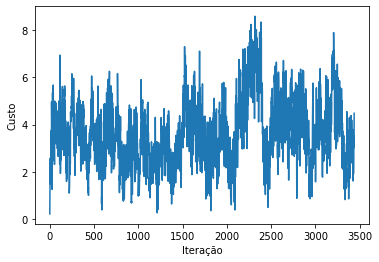

Fator Custo:  0.2
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



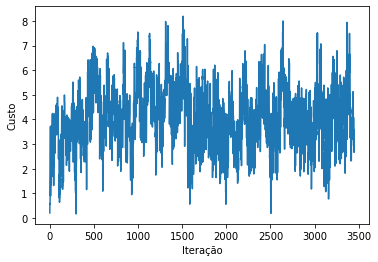

Fator Custo:  0.25
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



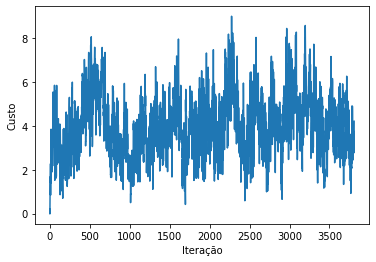

Fator Custo:  0.3
Objetivo Custo:  727.0
Objetivo Diferença:  13.0



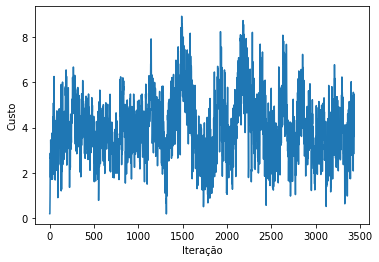

Fator Custo:  0.35
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



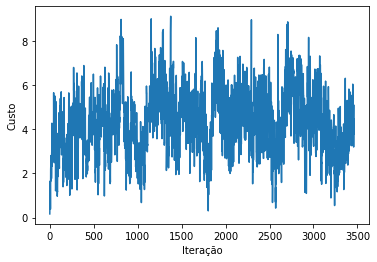

Fator Custo:  0.39999999999999997
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



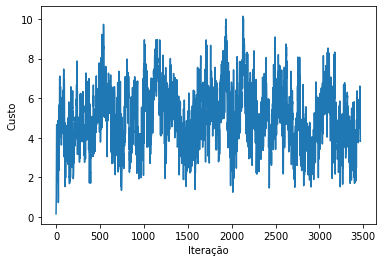

Fator Custo:  0.44999999999999996
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



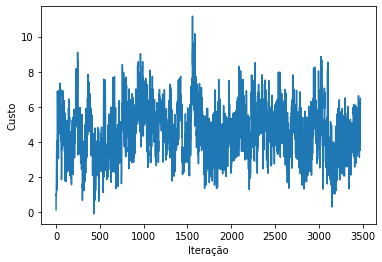

Fator Custo:  0.49999999999999994
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



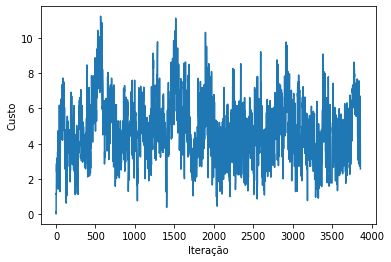

Fator Custo:  0.5499999999999999
Objetivo Custo:  715.0
Objetivo Diferença:  18.0



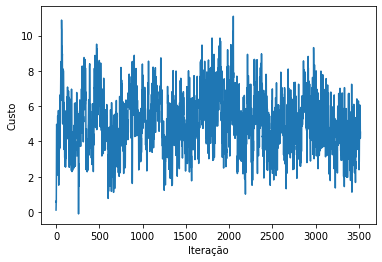

Fator Custo:  0.6
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



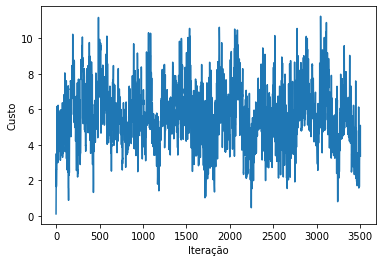

Fator Custo:  0.65
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



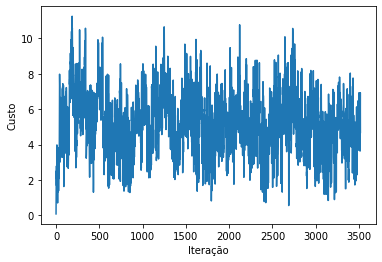

Fator Custo:  0.7000000000000001
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



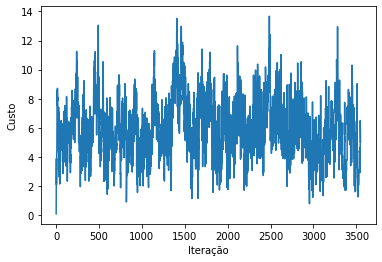

Fator Custo:  0.7500000000000001
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



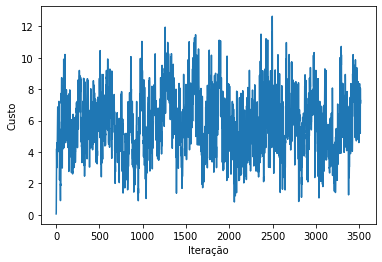

Fator Custo:  0.8000000000000002
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



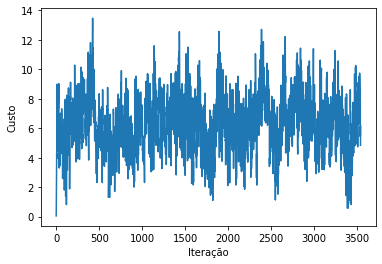

Fator Custo:  0.8500000000000002
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



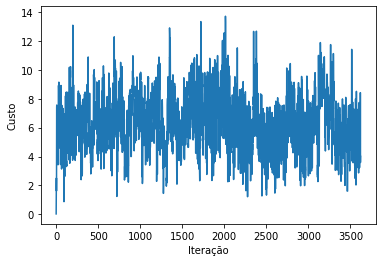

Fator Custo:  0.9000000000000002
Objetivo Custo:  714.0
Objetivo Diferença:  31.0



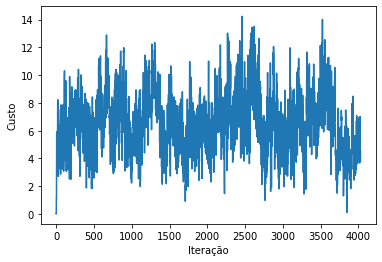

Fator Custo:  0.9500000000000003
Objetivo Custo:  715.0
Objetivo Diferença:  17.0

Tempo de Execução:  85.84905099868774


In [ ]:
inicio = time.time()
fator_custo = 0
pareto = []
for i in range(20):
  mat_melhor_solucao, norm, vet_custos = SA_norm(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, normalizacao, fator_custo)
  
  custo = fobjc(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_melhor_solucao, True)
  dif = fobje(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_melhor_solucao, True)

  pareto.append( front_pareto(mat_melhor_solucao, norm, custo, dif, fator_custo) )
  print('Fator Custo: ', pareto[i].fator)
  #print('Objetivos Ponderados: ', pareto[i].norm)
  print('Objetivo Custo: ', pareto[i].custo)
  print('Objetivo Diferença: ', pareto[i].dif)
  print('')
  fator_custo = fator_custo + 0.05
fim = time.time()
print('Tempo de Execução: ', fim-inicio)

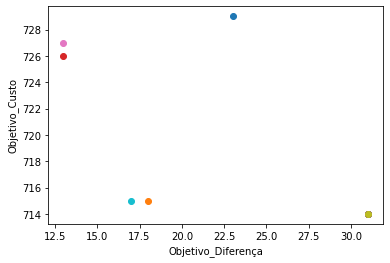

In [ ]:
for i in range(20):
  plt.scatter(pareto[i].dif,pareto[i].custo)
plt.ylabel('Objetivo_Custo')
plt.xlabel('Objetivo_Diferença')
plt.show()